# Udacity Self-Driving Car Project: Advanced Lane Finding
**By Elisa Chang**
___
#### The goals of this project are:
* To make the lane detection pipeline more robust to changes in lane color and changes in lighting conditions than when we first implemented the pipeline in the [CarND-LaneLines-P1](https://github.com/eeeja/CarND-LaneLines-P1) implementation.
* To calculate the curvature of the lanes so that we can adjust the steering wheel correctly.
___
#### We do this by using the following techniques:
Analysis:
1. [Correct Radial Distortion](#correct-radial-distortion): Compute and correct the camera calibration matrix and distortion coefficients given a set of chessboard images.
    * [Calibrate Camera](#calibrate-camera)
    * [Undistort Image](#undistort-image)
2. [Find Lane Lines](#find-lane-lines): Use color transforms & pixel gradients to detect lane line edges.
    * [ID Best Color Maps](#id-best-color-maps)
    * [Find Sobel Gradients](#find-sobel-gradients)
3. [Calculate Lane Line Curvature](#calculate-lane-line-curvature): Apply a perspective transform to rectify binary image ("birds-eye view").
    * [Calculate Birdseye Perspective](#calculate-birdseye-perspective)
    * [Detect lane pixels](#detect-lane-pixels)
    * [Determine Lane Curvature](#determine-lane-curvature)

Putting the Pipeline together: 
This notebook explores in detail the python implementation of the lane detection pipeline. For a more analytical overview of the pipeline, please see [Writeup](https://github.com/eeeja/CarND-LaneLines-P1/blob/master/P1.ipynb) located at './Writeup.md'
___

### <a name="radial-distortion">Correct Radial Distortion</a>
Image Distortion happens when a 3D object is transformed to a 2D image. There are two forms of image distortion: Radial and perspective distortion. Here we focus on correcting the radial distortion. Further down at [Calculate Birdseye Perspective](#calculate-birdseye-perspective) we will adjust for the perspective distortion. 

Radial Distortion happens when curved lenses in cameras bend light rays too much at the edge of lenses-- edges of images appear more/less curved than they actually are.

$$x_{corrected} = x(1+k_1r^2+k_2r^4+k_3r^6)$$
$$y_{corrected} = y(1+k_1r^2+k_2r^4+k_3r^6)$$
___
#### <a name="calibrate-camera">Calibrate Camera</a>
To fix radial distortion, first we begin by calibrating our camera. We do this by analyzing the checker images in the "./camera_cal" folder to determine what the camera matrix and distortion coefficients are. We need these values to understand how the camera lens distorts images when transforming from 3D objects to 2D images.

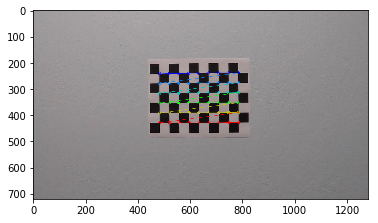

In [701]:
# Use cv2 functions findChessboardCorners() and drawChessboardCorners() 
# to find and draw corners of an imageimport numpy as np
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Number of corners inside the checker image in X and Y dimensions
nx = 9# Manually counted corners within the image
ny = 6# Manually counted corners within the image

# Image 1: 
# Make a list of calibration images
# Edited image in Paint so it could have a white background
fname = './camera_cal/calibration6.jpg' 
img = cv2.imread(fname)

# Image 2:
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Image 3:
# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
checker_img = img.copy()
# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(checker_img, (nx, ny), corners, ret)
    plt.imshow(checker_img)

#### <a name="undistort-image">Undistort Image</a>
We need to run the above for all the checker images so that we can have a collection of image (distorted) points and object (undistorted) points. 

    "Image points" refer to the x,y,z coordinates of an object as displayed on the image. 
    "Object points" refer to the x,y,z coordinates of an object as displayed in real life.
    For both of these points, we assume the z coordinate is 0.

Below is a mini-pipeline which will process all images in the *camera_cal* folder to collect the image and object points. Code we ran above is aggregated below. The checker corner images and resulting corresponding undistorted are output to the *output_images* folder.

In [469]:
# Helper methods used below

# TODO: Write a function that takes an image, object points, and image points
# performs the camera calibration, image distortion correction and 
# returns the undistorted image
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    # undist = np.copy(img)  # Delete this line
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

In [702]:
# Retrieve all images
# This loop might take some time since it is iterating and processing all camera_cal images
images = glob.glob('./camera_cal/calibration*.jpg')

# Create output folder if it doesn't exist
output_folder = './output_images'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Camera Calibration variables to fix optical distortion from lens
objpoints = [] #3D points in real world space
imgpoints = [] #2D points on image

# Returns an array of object points
# Z dim will always be 0
objp = np.zeros((nx*ny, 3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2) #x, y coordinates

# Read in all images in camera_cal folder
# Collect imgpoints to use to undistort
for fname in images:
    img = cv2.imread(fname)

    # Step 1: Calibrate Camera 
    # We will use the camera calibrations detected from the checker images to determine the 
    # intrinsic camera properties which we will use downstream for our car camera images to 
    # undistort the video stream.
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, draw corners
    if ret == True:
        # Append relevant points to use later on when undistorting images
        imgpoints.append(corners)
        objpoints.append(objp)
        checkered_img = img.copy()

        # Draw and display the corners
        cv2.drawChessboardCorners(checkered_img, (nx, ny), corners, ret)
        
        # Save id'd points to output folder
        save_fname = os.path.join(output_folder,'chessBoardCorners_' + os.path.basename(fname))
        cv2.imwrite(save_fname, checkered_img)

# Undistort Image
for fname in images:
    img = cv2.imread(fname)

    # Step 2: Correct for Distortion 
    undistorted = cal_undistort(img, objpoints, imgpoints)
    save_fname = os.path.join(output_folder,'undistorted_' + os.path.basename(fname))

    cv2.imwrite(save_fname, undistorted)

Here is an example of an original input image vs the undistorted output the above code generated. Notice how you can see some minor radial distortion on the right hand side where the edge of the board curves inside. While the right hand side of the undistorted image is straighter than the original image.

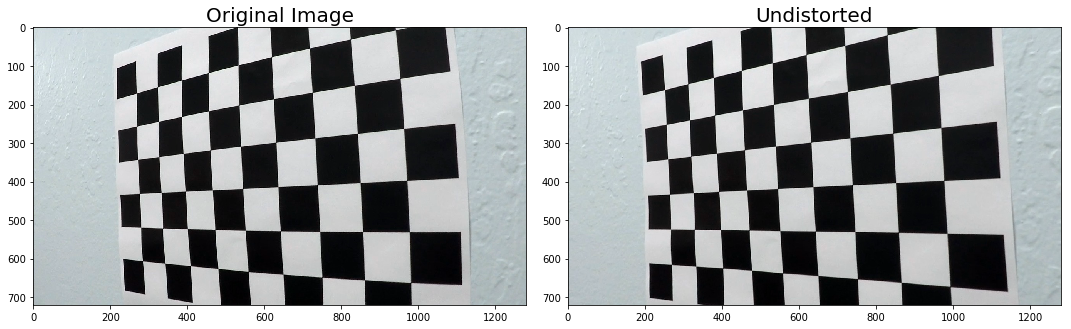

In [716]:
# Display sample distorted and undistorted images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
f.tight_layout()
fname = './camera_cal/calibration4.jpg'
img = cv2.imread(fname)
undistorted = cv2.imread('./output_images/undistorted_calibration4.jpg')
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted)
ax2.set_title('Undistorted', fontsize=20)
save_fname = os.path.join(output_folder,'orig_vs_undistorted_' + os.path.basename(fname))
f.savefig(save_fname, bbox_inches='tight')

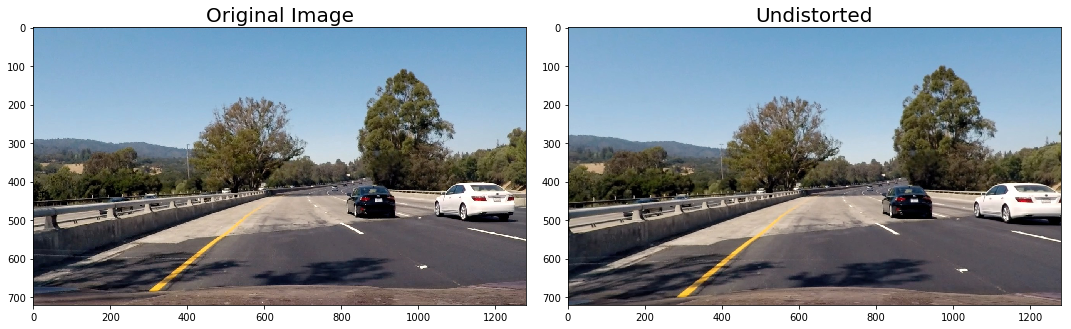

In [718]:
# Replicate with a road image
fname = './test_images/test4.jpg'
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Correct for Distortion 
undistorted = cal_undistort(img, objpoints, imgpoints)
# Save image for use downstream
save_fname = os.path.join(output_folder,'undistorted_' + os.path.basename(fname))
cv2.imwrite(save_fname, undistorted)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undistorted)
ax2.set_title('Undistorted', fontsize=20)
save_fname = os.path.join(output_folder,'orig_vs_undistorted_' + os.path.basename(fname))
f.savefig(save_fname, bbox_inches='tight')

### <a name="find-lane-lines">Find Lane Lines</a>
Now that we have adjusted for some of the optical distortions caused my the camera lens, we can begin manipulating the images to find the lane lines. 

Lane lines can be hard to detect in different lighting conditions and when they are different colors. Below we observe what color maps and gradients best bring out yellow and white lane lines in shadows and in the light.
___
#### <a name="id-best-color-maps">ID Best Color Maps</a>
Once we extract the specific channel we want to view, I run the image through a threshold filter to only pick up on pixels of a certain range of threshold. We had to modify the threshold value for the light vs dark road images. As the pipeline gets further refined downstream, these thresholds would have to be automatically adjusted as the lighting conditions change on the road.

**RGB color map on bright & dark roads:** 

*Analysis:* 
* The *B* (blue) values cannot capture yellow lines well.
* The *R* value seems to capture yellow and white lane lines well in both light and dark roads

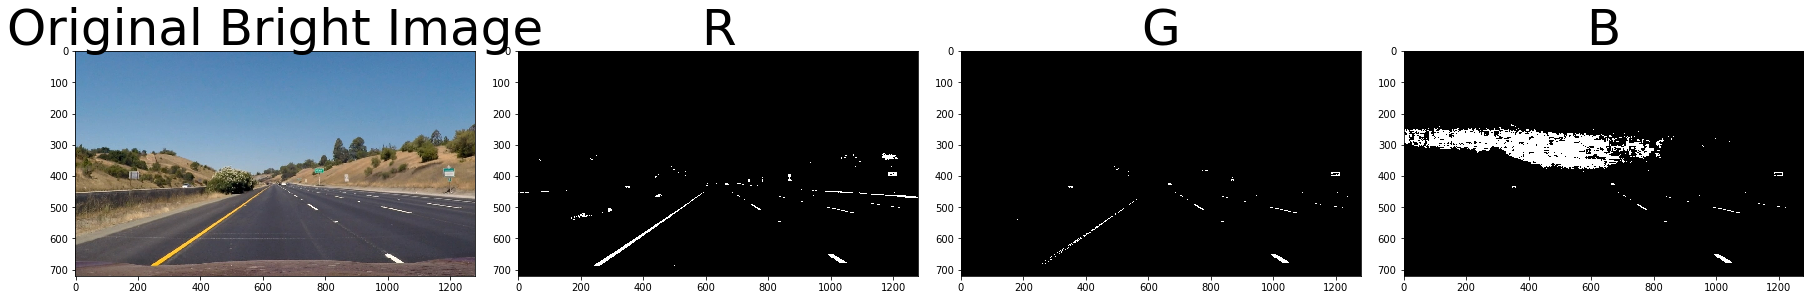

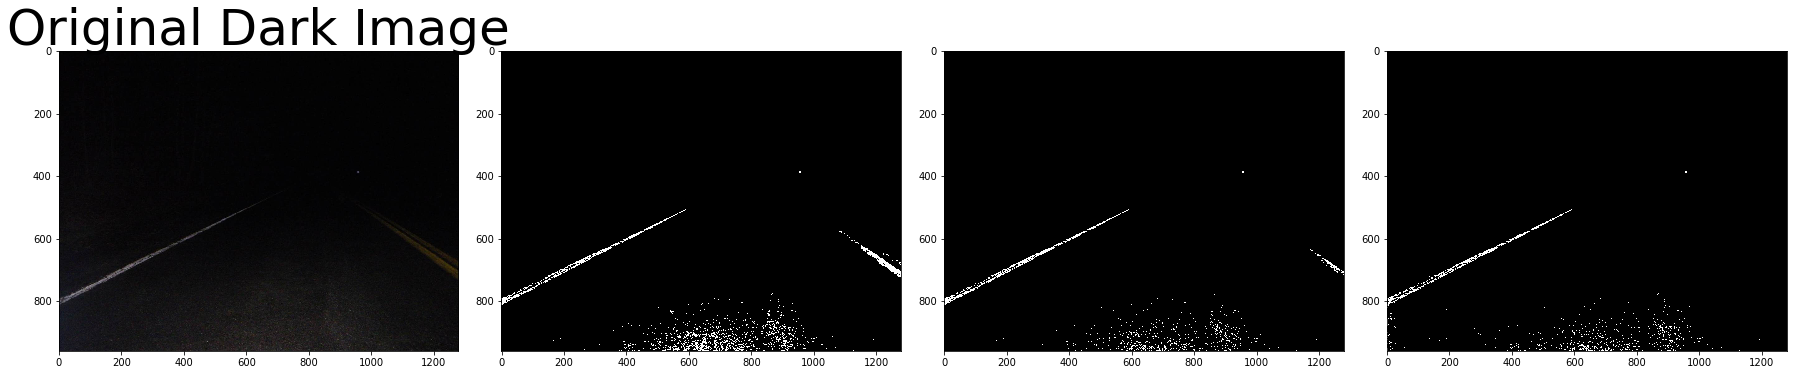

In [574]:
# Helper function to get binary images
def get_binary(image, threshold=(0,255)):
    binary = np.zeros_like(image)
    binary[(image>threshold[0]) & (image<=threshold[1])] = 1
    return binary

fname = './test_images/straight_lines1.jpg'
light_threshold = (200,255)
# cv2 reads in image as BGR
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Bright Image', fontsize=50)
r_binary = get_binary(img[:,:,(0)], threshold=light_threshold)
ax2.imshow(r_binary, cmap = 'gray')
ax2.set_title('R', fontsize=50)
g_binary = get_binary(img[:,:,(1)], threshold=light_threshold)
ax3.imshow(g_binary, cmap = 'gray')
ax3.set_title('G', fontsize=50)
g_binary = get_binary(img[:,:,(2)], threshold=light_threshold)
ax4.imshow(g_binary, cmap = 'gray')
ax4.set_title('B', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

fname = './Elisa_Images/additionalDarkRoadTest.jpg'
dark_threshold = (40,100)
# cv2 reads in image as BGR
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Dark Image', fontsize=50)
r_binary = get_binary(img[:,:,(0)], threshold=dark_threshold)
ax2.imshow(r_binary, cmap = 'gray')
g_binary = get_binary(img[:,:,(1)], threshold=dark_threshold)
ax3.imshow(g_binary, cmap = 'gray')
g_binary = get_binary(img[:,:,(2)], threshold=dark_threshold)
ax4.imshow(g_binary, cmap = 'gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

___
**HSV color map on bright & dark roads:** HSV stands for hue, saturation, and value. Read more on how the color representation is calculated [here](http://codeitdown.com/hsl-hsb-hsv-color/)

*Analysis:* 
* The *value* field seems to be best at identifying white and yellow lines for both well lit and dark images

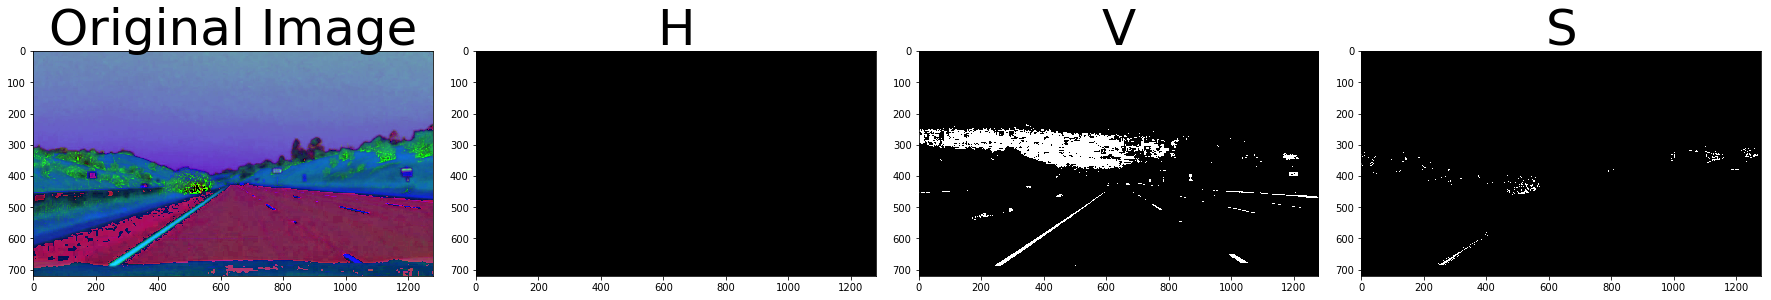

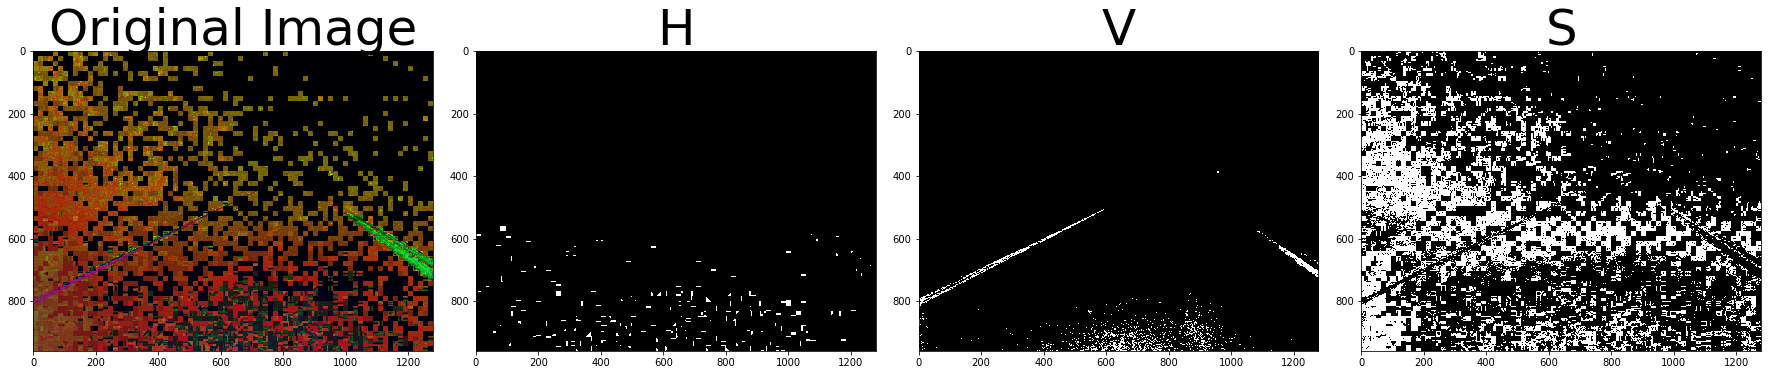

In [575]:
fname = './test_images/straight_lines1.jpg' 
# Try playing with other color spaces: HSV
img = cv2.imread(fname)
img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)

h_binary = get_binary(img[:,:,(0)],threshold=light_threshold)
ax2.imshow(h_binary, cmap='gray')
ax2.set_title('H', fontsize=50)

v_binary = get_binary(img[:,:,(2)],threshold=light_threshold)
ax3.imshow(v_binary, cmap='gray')
ax3.set_title('V', fontsize=50)

s_binary = get_binary(img[:,:,(1)],threshold=light_threshold)
ax4.imshow(s_binary, cmap='gray')
ax4.set_title('S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Dark Image
fname = './Elisa_Images/additionalDarkRoadTest.jpg' 
# Try playing with other color spaces: HSV
img = cv2.imread(fname)
img = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)

h_binary = get_binary(img[:,:,(0)],threshold=dark_threshold)
ax2.imshow(h_binary, cmap='gray')
ax2.set_title('H', fontsize=50)

v_binary = get_binary(img[:,:,(2)],threshold=dark_threshold)
ax3.imshow(v_binary, cmap='gray')
ax3.set_title('V', fontsize=50)

s_binary = get_binary(img[:,:,(1)],threshold=dark_threshold)
ax4.imshow(s_binary, cmap='gray')
ax4.set_title('S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

___
**HLS color map on bright road:** HLS stands for hue, lightness, and saturation. 

*Analysis:*
* The *saturation* field is able to capture both white and yellow lines. This is because the saturation value in *HLS* is depenedent on the associated lightness of the pixel, and not just its intensity. 
* The *lightness* dimension doesn't bring out the lane lines as much as the *value* dimension in the *HSV* space. This might be because *lightness* is an average of the brightest and darkest RGB values, while the *value* is simply the brightest value. 

**HLS color map on dark road:**

*Analysis:* 
* The saturation field cannot capture white lanes well in dark lighting

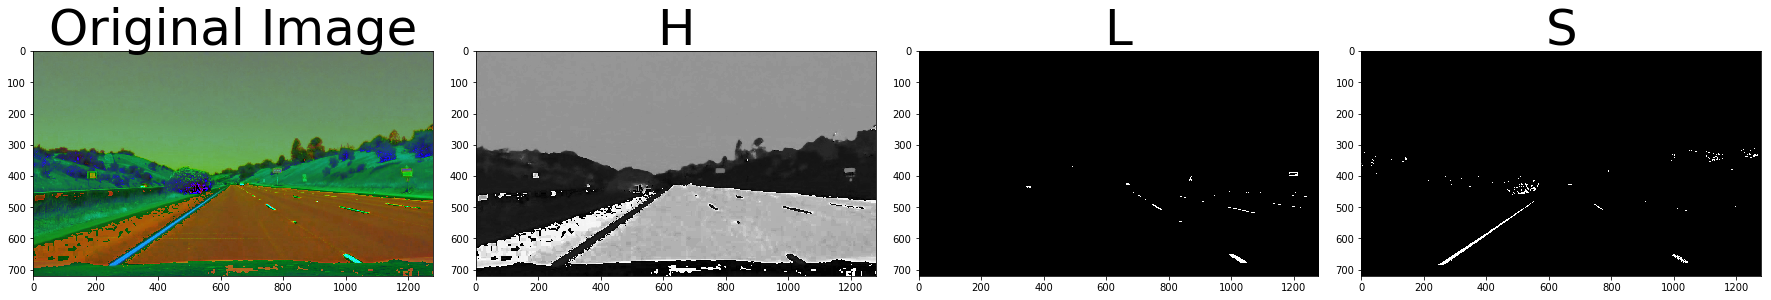

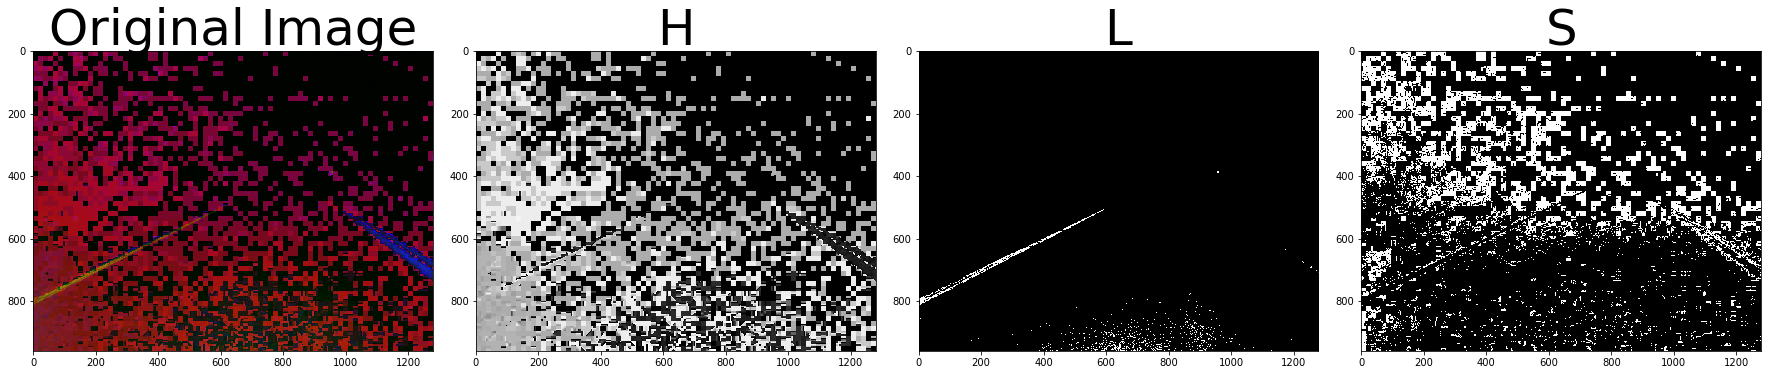

In [577]:
fname = './test_images/straight_lines1.jpg' 
# Try playing with other color spaces: HLS
img = cv2.imread(fname)
img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)

h_binary = get_binary(img[:,:,(0)],threshold=light_threshold)
ax2.imshow(img[:,:,(0)], cmap='gray')
ax2.set_title('H', fontsize=50)

l_binary = get_binary(img[:,:,(1)],threshold=light_threshold)
ax3.imshow(l_binary, cmap='gray')
ax3.set_title('L', fontsize=50)

s_binary = get_binary(img[:,:,(2)],threshold=light_threshold)
ax4.imshow(s_binary, cmap='gray')
ax4.set_title('S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Compare with dark road
fname = './Elisa_Images/additionalDarkRoadTest.jpg' 
# Try playing with other color spaces: HLS
img = cv2.imread(fname)
img = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)

h_binary = get_binary(img[:,:,(0)],threshold=dark_threshold)
ax2.imshow(img[:,:,(0)], cmap='gray')
ax2.set_title('H', fontsize=50)

l_binary = get_binary(img[:,:,(1)],threshold=dark_threshold)
ax3.imshow(l_binary, cmap='gray')
ax3.set_title('L', fontsize=50)

s_binary = get_binary(img[:,:,(2)],threshold=dark_threshold)
ax4.imshow(s_binary, cmap='gray')
ax4.set_title('S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

**Color map conclusions:**
* Specifically to bring out white and yellow lanes, we should ignore the blue values
* Within the *HVS* color map, the *value* field is best in both bright and dark lighting situations at bringing out white and yellow lanes.
* WIthin the *HLS* color map, the *saturation* field brings out lane lines best in bright images, but is not as reliable in detecting white lanes in dark lighting. 

Using these observations, it seems like we could maximize our lane detection if we do not use B values and if we use the *value* field in the HVS color map. 

___
#### <a name="find-sobel-gradients">Find Sobel Gradients</a>
The sobel operator is a [convolution](http://setosa.io/ev/image-kernels/) matrix which is used to approximate the changes in pixel intensity (gradient). A 3x3 kernel looks like: 

$G_x = 
\left[ \begin{array}{cccc}
1 & 0 & -1 \\
2 & 0 & -2 \\
1 & 0 & -1 \\ \end{array} \right] * A$

$G_y = 
\left[ \begin{array}{cccc}
1 & 2 & 1 \\
0 & 0 & 0 \\
-1 & -2 & -1 \\ \end{array} \right] * A$

The key properties of the sobel operator is that it is depending on if you're look at the x or y gradient, the kernel has symmetric but opposite direction values in the first half/top half of the matrix to the second half/bottom half. This causes the convolution to return 0 if the pixels in the surrounding area are similar and will return larger values otherwise, consequently highlighting edges. Below we look at the edges detected using the sobel operators on a normal image, then on an image that has been enhanced leveraging our observations from analysis on different color maps.

We use the sobel operator here rather than the canny edge detection algorithm so that we can focus on finding edges of a certain direction (more vertical rather than horizontal) so that we could customize that edge detection process to only return edges most likely to be lane lines. 
___
**Sobel Operators on original image**
Below we collect different gradients. In the next section, we will compare gradients extracted from the original image vs gradients extracted from an image with the color map manipulated.

In [354]:
## Helper Methods
## All these methods assume the image has been converted to a gray-scale image

# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
# Note: calling your function with orient='x', thresh_min=5, thresh_max=100
# should produce output like the example image shown above this quiz.
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output


# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # 3) Calculate the magnitude 
    # abs_sobelx = np.sqrt(sobelx*sobelx)
    abs_sobelxy = np.sqrt(sobely*sobely+sobelx*sobelx)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    # binary_output = np.copy(img) # Remove this line
    return binary_output

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel))
    sobely = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel))
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.sqrt(sobelx*sobelx)
    abs_sobely = np.sqrt(sobely*sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir =  np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output = np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output
    
    
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # 2) Apply a threshold to the S channel
    #s_thresh = [hls_img[:,:,(2)] >= thresh[1] & hls_img[:,:,(2)] < thresh[0]]
    
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(hls_img[:,:,(2)])
    binary_output[(hls_img[:,:,(2)] <= thresh[1]) & (hls_img[:,:,(2)] > thresh[0])] = 1
    return binary_output

**Sobel Operator on Image with manipulated Color map**
The cvtColor documentation states that the alorithm used to convert RGB to color is
$$Y = 0.299 R + 0.587 G + 0.114 B$$
Knowing this, we will replace the $B$ value with $R$, since the red value seemed to bring out the lane lines best from the above RGB on dark and bright road sections.

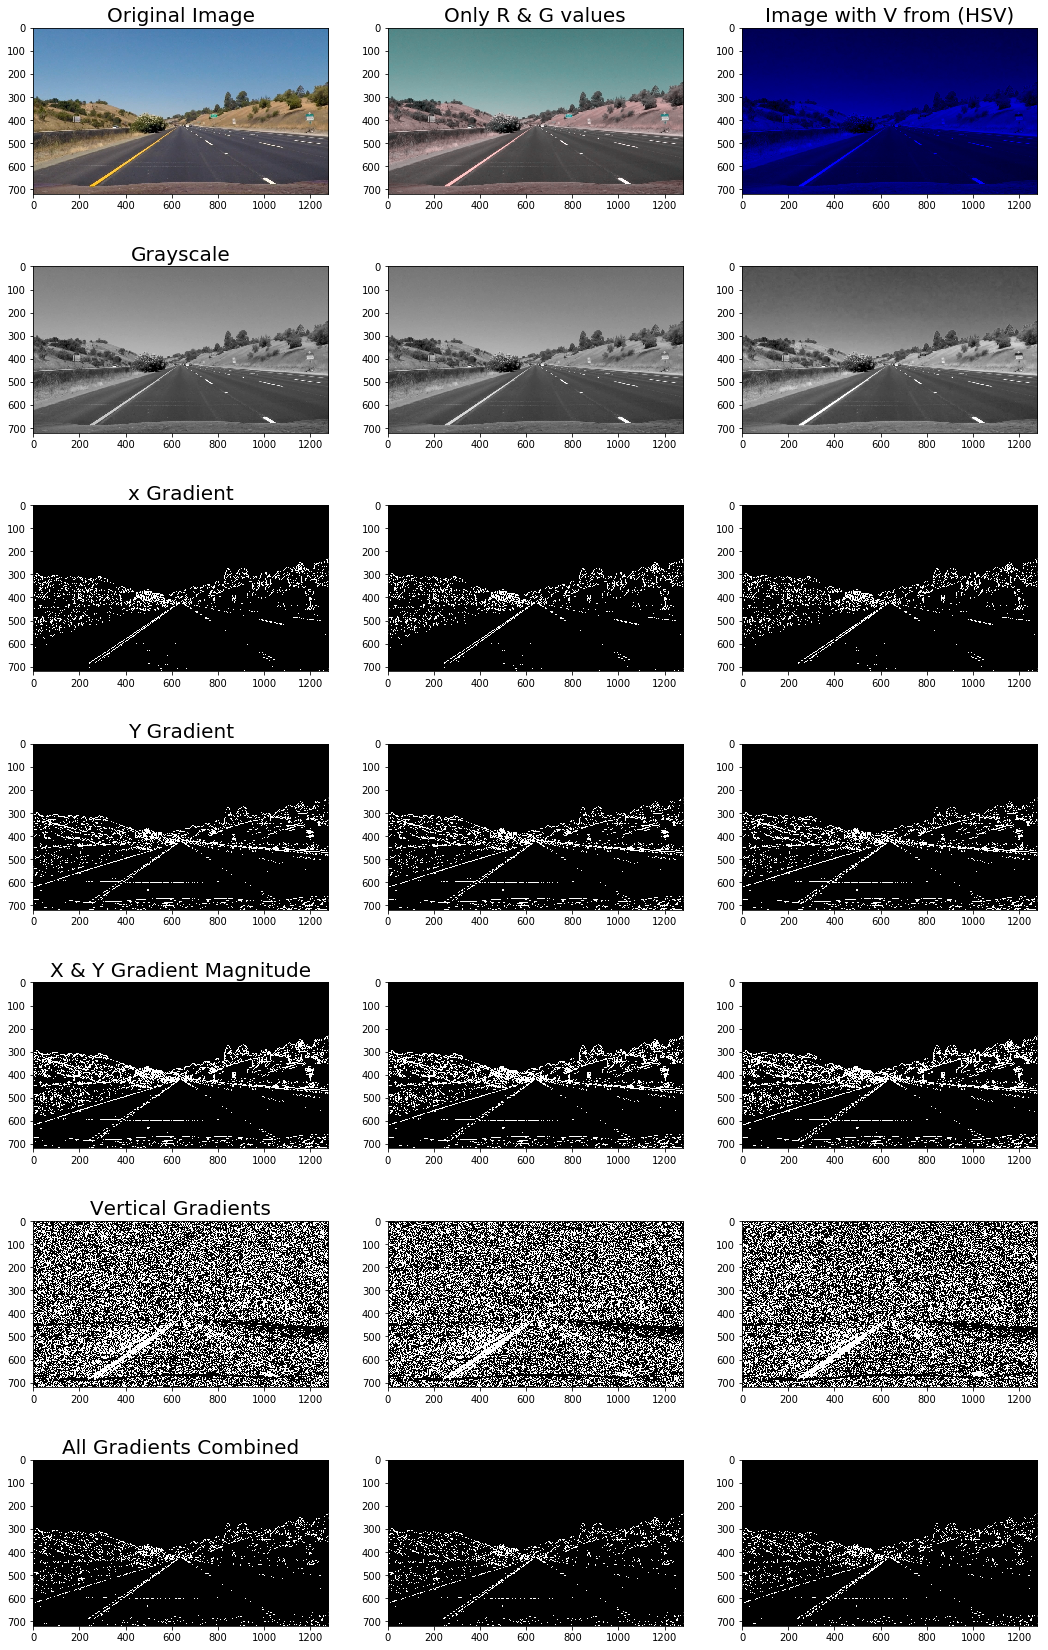

In [662]:
###### Find best threshold parameters
fname = './test_images/straight_lines1.jpg' 
img = cv2.imread(fname)
# Image 1: Original
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# Image 2: Grayscale
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

# Image 3: x Gradient
gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))

# Image 4: y Gradient
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))

# Image 5: X & Y Gradient magnitude
mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(20, 100))

# Image 6: Only gradients that are  almost verticle-- most likely to be lane lines
# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))

# Image 7: All gradients combied
# Combine all gradients
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#combined[((gradx == 1) & (dir_binary == 1))] = 1

# See images output below

# Image 1: Only R&G Values
RG_img = img.copy()
RG_img[:,:,2] = img[:,:,1]

# Image 2: Grayscale of only R&G Values
RG_gray = cv2.cvtColor(RG_img,cv2.COLOR_RGB2GRAY)

# Image 3: x Gradient of only R&G Values
RG_gradx = abs_sobel_thresh(RG_gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))

# Image 4: y Gradient of only R&G Values
RG_grady = abs_sobel_thresh(RG_gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))

# Image 5: X & Y Gradient magnitude of only R&G Values
RG_mag_binary = mag_thresh(RG_gray, sobel_kernel=ksize, mag_thresh=(20, 100))

# Image 6: Only gradients that are  almost verticle-- most likely to be lane lines
RG_dir_binary = dir_threshold(RG_gray, sobel_kernel=ksize, thresh=(0.7, 1.3))

# Image 7: All gradients combined of only R&G Values 
# Combine all gradients
RG_combined = np.zeros_like(RG_dir_binary)
RG_combined[((RG_gradx == 1) & (RG_grady == 1)) | ((RG_mag_binary == 1) & (RG_dir_binary == 1))] = 1
#RG_combined[(RG_gradx == 1) & (RG_dir_binary == 1)] = 1

### HSV 
# Image 1: Only R&G Values
HSV_img = img.copy()
HSV_img[:,:,1] = HSV_img[:,:,0]
HSV_img[:,:,2] = HSV_img[:,:,0]
HSV_img = cv2.cvtColor(HSV_img, cv2.COLOR_RGB2HSV)

# Image 2: Grayscale of only R&G Values
HSV_gray = HSV_img[:,:,2]#cv2.cvtColor(HSV_img,cv2.COLOR_BGR2GRAY)

# Image 3: x Gradient of only R&G Values
HSV_gradx = abs_sobel_thresh(HSV_gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))

# Image 4: y Gradient of only R&G Values
HSV_grady = abs_sobel_thresh(HSV_gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))

# Image 5: X & Y Gradient magnitude of only R&G Values
HSV_mag_binary = mag_thresh(HSV_gray, sobel_kernel=ksize, mag_thresh=(20, 100))

# Image 6: Only gradients that are  almost verticle-- most likely to be lane lines
HSV_dir_binary = dir_threshold(HSV_gray, sobel_kernel=ksize, thresh=(0.7, 1.3))

# Image 7: All gradients combined of only R&G Values 
# Combine all gradients
HSV_combined = np.zeros_like(HSV_dir_binary)
HSV_combined[((HSV_gradx == 1) & (HSV_grady == 1)) | ((HSV_mag_binary == 1) & (HSV_dir_binary == 1))] = 1
#HSV_combined[((HSV_gradx == 1) & (RG_dir_binary == 1))] = 1

#plot all original images
fig = plt.figure(figsize = (18,30))
ax1 = fig.add_subplot(731)
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(img)
ax4 = fig.add_subplot(734)
ax4.set_title('Grayscale', fontsize=20)
ax4.imshow(gray, cmap='gray')
ax7 = fig.add_subplot(737)
ax7.set_title('x Gradient', fontsize=20)
ax7.imshow(gradx, cmap = 'gray')
ax10 = fig.add_subplot(7,3,10)
ax10.set_title('Y Gradient', fontsize=20)
ax10.imshow(grady, cmap = 'gray')
ax13 = fig.add_subplot(7,3,13)
ax13.set_title('X & Y Gradient Magnitude', fontsize=20)
ax13.imshow(mag_binary,cmap='gray')
ax16 = fig.add_subplot(7,3,16)
ax16.set_title('Vertical Gradients', fontsize=20)
ax16.imshow(dir_binary,cmap='gray')
ax19 = fig.add_subplot(7,3,19)
ax19.set_title('All Gradients Combined', fontsize=20)
ax19.imshow(combined,cmap='gray')

#plot all images with manipulated color spalce
ax2 = fig.add_subplot(732)
ax2.set_title('Only R & G values', fontsize=20)
ax2.imshow(RG_img)
ax5 = fig.add_subplot(735)
ax5.imshow(RG_gray, cmap='gray')
ax8 = fig.add_subplot(738)
ax8.imshow(RG_gradx, cmap = 'gray')
ax11 = fig.add_subplot(7,3,11)
ax11.imshow(RG_grady, cmap = 'gray')
ax14 = fig.add_subplot(7,3,14)
ax14.imshow(RG_mag_binary,cmap='gray')
ax17 = fig.add_subplot(7,3,17)
ax17.imshow(RG_dir_binary,cmap='gray')
ax20 = fig.add_subplot(7,3,20)
ax20.imshow(RG_combined,cmap='gray')

#plot all images with manipulated color spalce
ax3 = fig.add_subplot(733)
ax3.set_title('Image with V from (HSV)', fontsize=20)
ax3.imshow(HSV_img)
ax6 = fig.add_subplot(736)
ax6.imshow(HSV_gray, cmap='gray')
ax9 = fig.add_subplot(739)
ax9.imshow(HSV_gradx, cmap = 'gray')
ax12 = fig.add_subplot(7,3,12)
ax12.imshow(HSV_grady, cmap = 'gray')
ax15 = fig.add_subplot(7,3,15)
ax15.imshow(HSV_mag_binary,cmap='gray')
ax18 = fig.add_subplot(7,3,18)
ax18.imshow(HSV_dir_binary,cmap='gray')
ax21 = fig.add_subplot(7,3,21)
ax21.imshow(HSV_combined,cmap='gray')

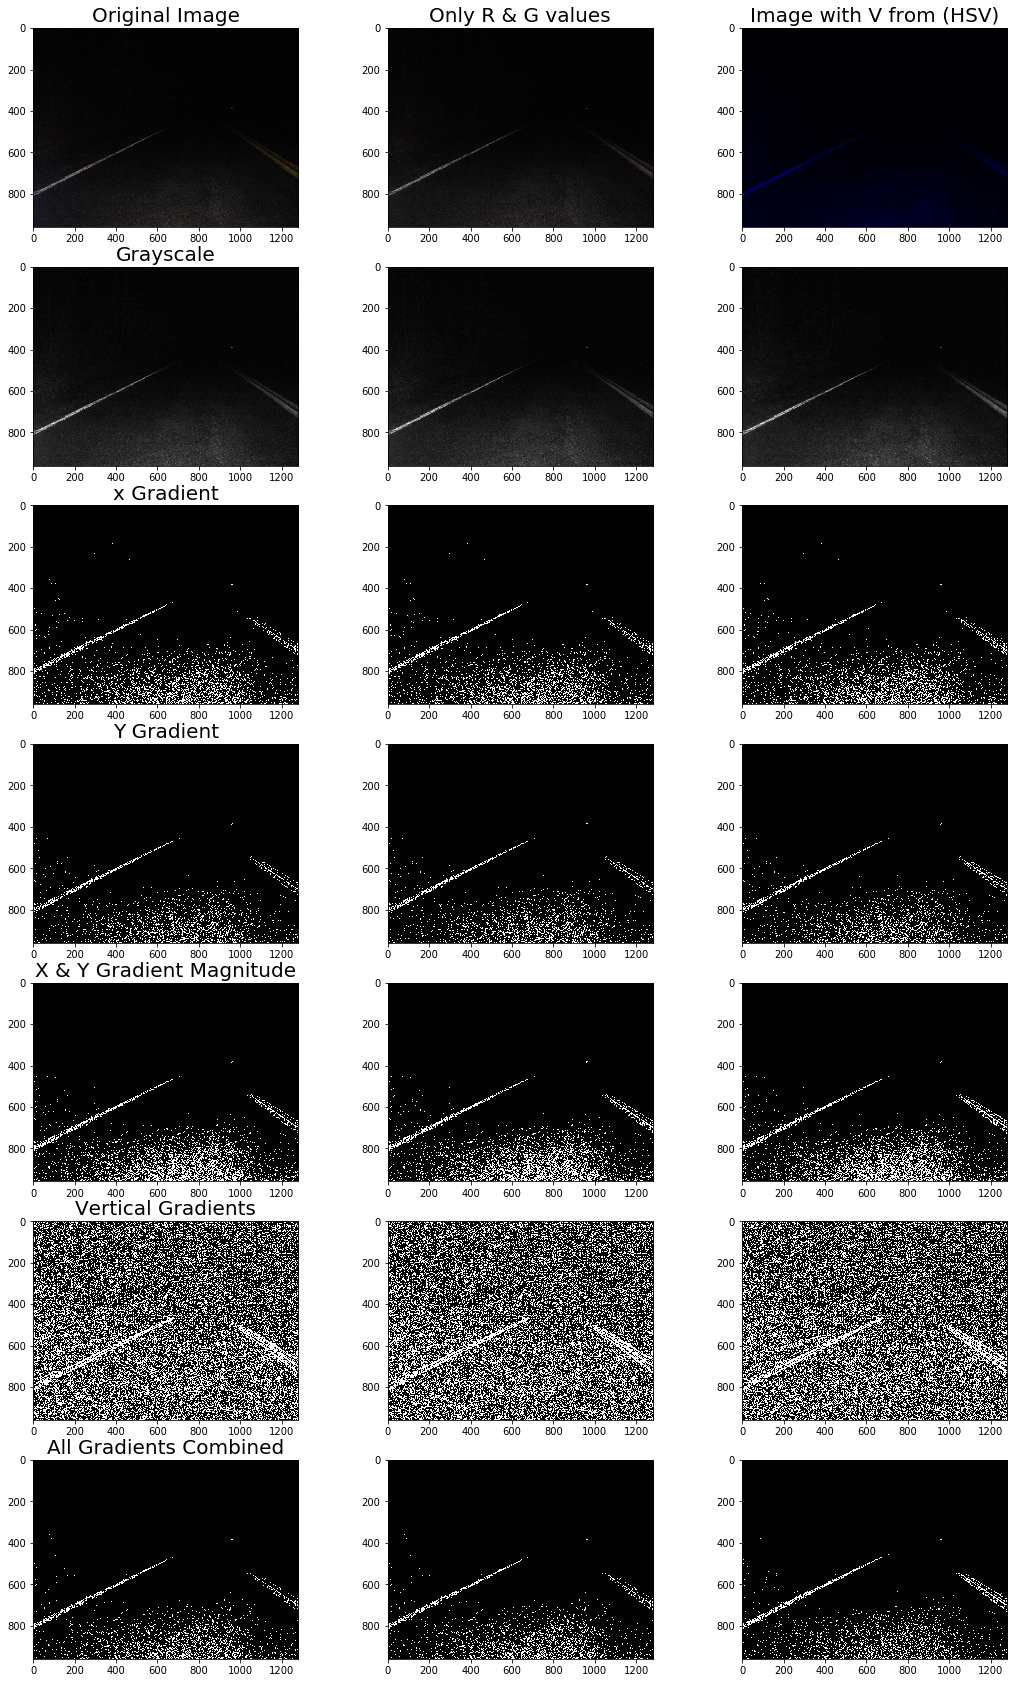

In [512]:
# Repeat above with image of road with dark lighting
###### Find best threshold parameters
fname = './Elisa_Images/additionalDarkRoadTest.jpg' 
img = cv2.imread(fname)
# Image 1: Original
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

# Image 2: Grayscale
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

# Image 3: x Gradient
gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))

# Image 4: y Gradient
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))

# Image 5: X & Y Gradient magnitude
mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(20, 100))

# Image 6: Only gradients that are  almost verticle-- most likely to be lane lines
# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.7, 1.3))

# Image 7: All gradients combied
# Combine all gradients
dark_combined = np.zeros_like(dir_binary)
dark_combined[((gradx == 1) & (grady == 1)) 
         | ((gradx == 1) & (dir_binary == 1))
         | ((mag_binary == 1) & (gradx == 1))] = 1
#combined[((gradx == 1) & (dir_binary == 1))] = 1

# See images output below
# Image 1: Only R&G Values
RG_img = img.copy()
RG_img[:,:,2] = img[:,:,1]

# Image 2: Grayscale of only R&G Values
RG_gray = cv2.cvtColor(RG_img,cv2.COLOR_RGB2GRAY)

# Image 3: x Gradient of only R&G Values
RG_gradx = abs_sobel_thresh(RG_gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))

# Image 4: y Gradient of only R&G Values
RG_grady = abs_sobel_thresh(RG_gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))

# Image 5: X & Y Gradient magnitude of only R&G Values
RG_mag_binary = mag_thresh(RG_gray, sobel_kernel=ksize, mag_thresh=(20, 100))

# Image 6: Only gradients that are  almost verticle-- most likely to be lane lines
RG_dir_binary = dir_threshold(RG_gray, sobel_kernel=ksize, thresh=(0.7, 1.3))

# Image 7: All gradients combined of only R&G Values 
# Combine all gradients
RG_combined = np.zeros_like(RG_dir_binary)
RG_combined[((RG_gradx == 1) & (RG_grady == 1)) 
            | ((RG_gradx == 1) & (RG_dir_binary == 1))
            | ((RG_mag_binary == 1) & (RG_gradx == 1))] = 1
#RG_combined[(RG_gradx == 1) & (RG_dir_binary == 1)] = 1

### HSV 
# Image 1: Only R&G Values
HSV_img = img.copy()
HSV_img[:,:,1] = HSV_img[:,:,0]
HSV_img[:,:,2] = HSV_img[:,:,0]
HSV_img = cv2.cvtColor(HSV_img, cv2.COLOR_RGB2HSV)

# Image 2: Grayscale of only R&G Values
HSV_gray = HSV_img[:,:,2]#cv2.cvtColor(HSV_img,cv2.COLOR_BGR2GRAY)

# Image 3: x Gradient of only R&G Values
HSV_gradx = abs_sobel_thresh(HSV_gray, orient='x', sobel_kernel=ksize, thresh=(20, 100))

# Image 4: y Gradient of only R&G Values
HSV_grady = abs_sobel_thresh(HSV_gray, orient='y', sobel_kernel=ksize, thresh=(20, 100))

# Image 5: X & Y Gradient magnitude of only R&G Values
HSV_mag_binary = mag_thresh(HSV_gray, sobel_kernel=ksize, mag_thresh=(20, 100))

# Image 6: Only gradients that are  almost verticle-- most likely to be lane lines
HSV_dir_binary = dir_threshold(HSV_gray, sobel_kernel=ksize, thresh=(0.7, 1.3))

# Image 7: All gradients combined of only R&G Values 
# Combine all gradients
HSV_combined = np.zeros_like(HSV_dir_binary)
HSV_combined[((HSV_gradx == 1) & (HSV_grady == 1)) 
            | ((HSV_gradx == 1) & (HSV_dir_binary == 1))
            | ((HSV_mag_binary == 1) & (HSV_dir_binary == 1))] = 1
#HSV_combined[((HSV_gradx == 1) & (RG_dir_binary == 1))] = 1

#plot all original images
fig = plt.figure(figsize = (18,30))
ax1 = fig.add_subplot(731)
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(img)
ax4 = fig.add_subplot(734)
ax4.set_title('Grayscale', fontsize=20)
ax4.imshow(gray, cmap='gray')
ax7 = fig.add_subplot(737)
ax7.set_title('x Gradient', fontsize=20)
ax7.imshow(gradx, cmap = 'gray')
ax10 = fig.add_subplot(7,3,10)
ax10.set_title('Y Gradient', fontsize=20)
ax10.imshow(grady, cmap = 'gray')
ax13 = fig.add_subplot(7,3,13)
ax13.set_title('X & Y Gradient Magnitude', fontsize=20)
ax13.imshow(mag_binary,cmap='gray')
ax16 = fig.add_subplot(7,3,16)
ax16.set_title('Vertical Gradients', fontsize=20)
ax16.imshow(dir_binary,cmap='gray')
ax19 = fig.add_subplot(7,3,19)
ax19.set_title('All Gradients Combined', fontsize=20)
ax19.imshow(combined,cmap='gray')

#plot all images with manipulated color spalce
ax2 = fig.add_subplot(732)
ax2.set_title('Only R & G values', fontsize=20)
ax2.imshow(RG_img)
ax5 = fig.add_subplot(735)
ax5.imshow(RG_gray, cmap='gray')
ax8 = fig.add_subplot(738)
ax8.imshow(RG_gradx, cmap = 'gray')
ax11 = fig.add_subplot(7,3,11)
ax11.imshow(RG_grady, cmap = 'gray')
ax14 = fig.add_subplot(7,3,14)
ax14.imshow(RG_mag_binary,cmap='gray')
ax17 = fig.add_subplot(7,3,17)
ax17.imshow(RG_dir_binary,cmap='gray')
ax20 = fig.add_subplot(7,3,20)
ax20.imshow(RG_combined,cmap='gray')

#plot all images with manipulated color spalce
ax3 = fig.add_subplot(733)
ax3.set_title('Image with V from (HSV)', fontsize=20)
ax3.imshow(HSV_img)
ax6 = fig.add_subplot(736)
ax6.imshow(HSV_gray, cmap='gray')
ax9 = fig.add_subplot(739)
ax9.imshow(HSV_gradx, cmap = 'gray')
ax12 = fig.add_subplot(7,3,12)
ax12.imshow(HSV_grady, cmap = 'gray')
ax15 = fig.add_subplot(7,3,15)
ax15.imshow(HSV_mag_binary,cmap='gray')
ax18 = fig.add_subplot(7,3,18)
ax18.imshow(HSV_dir_binary,cmap='gray')
ax21 = fig.add_subplot(7,3,21)
ax21.imshow(HSV_combined,cmap='gray')

**Gradient conclusions:**
* In both the dark and light images, the "Combined" image (last image) in the "HSV" column (the third column) appeared to depict best gradients-- though the differents seem subtle. 

In the final pipeline, we will make sure to only use *Red* and *Green* fields of an image and focus on the *Value* component of the HSV channel. 

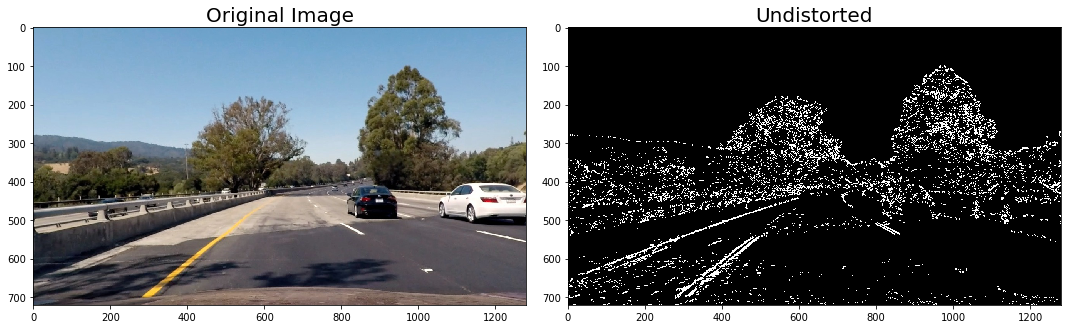

In [730]:
# Helper function that will take an image and return the R & G and Value gradients
def extract_lane_gradient(img,thresh=(0,255),dir_thresh=(0,1.5)):
    """Input RGB Image"""
    HSV_img = img.copy()
    #Use only R & G values --> assume input image is RGB
    HSV_img[:,:,2] = HSV_img[:,:,0]
    HSV_img = cv2.cvtColor(HSV_img, cv2.COLOR_RGB2HSV)

    # Image 2: Grayscale of only R&G Values
    HSV_gray = HSV_img[:,:,2]#cv2.cvtColor(HSV_img,cv2.COLOR_BGR2GRAY)

    # Image 3: x Gradient of only R&G Values
    HSV_gradx = abs_sobel_thresh(HSV_gray, orient='x', sobel_kernel=ksize, thresh=thresh)

    # Image 4: y Gradient of only R&G Values
    HSV_grady = abs_sobel_thresh(HSV_gray, orient='y', sobel_kernel=ksize, thresh=thresh)

    # Image 5: X & Y Gradient magnitude of only R&G Values
    HSV_mag_binary = mag_thresh(HSV_gray, sobel_kernel=ksize, mag_thresh=thresh)

    # Image 6: Only gradients that are  almost verticle-- most likely to be lane lines
    HSV_dir_binary = dir_threshold(HSV_gray, sobel_kernel=ksize, thresh=dir_thresh)

    # Image 7: All gradients combined of only R&G Values 
    # Combine all gradients
    HSV_combined = np.zeros_like(HSV_dir_binary)
    HSV_combined[((HSV_gradx == 1) & (HSV_grady == 1)) 
                | ((HSV_gradx == 1) & (HSV_dir_binary == 1))
                | ((HSV_mag_binary == 1) & (HSV_dir_binary == 1))] = 1
    return HSV_combined

# Plot figures to use in Writeup.md
fname = './output_images/undistorted_test4.jpg'
img = plt.imread(fname)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
binary = extract_lane_gradient(img, thresh=(20,100),dir_thresh=(0.7,1.3))
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(binary, cmap='gray')
ax2.set_title('Undistorted', fontsize=20)
save_fname = os.path.join(output_folder,'orig_vs_binary_' + os.path.basename(fname))
f.savefig(save_fname, bbox_inches='tight')

## <a name='calculate-lane-line-curvature'>Calculate Lane Line Curvature</a>
Now we transform the edges we detected into a birdseye perspective so we can more accurately measure the curve of the road.
___
* ** Tangential/Perspective Distortion: **
Objects in images look slanted because camera is not aligned perfectly parallel to the imaging plane.
(Source Udacity Self Driving Care Notes)
$$x_{corrected} = x+[2p_1xy+p_2(r^2+2x^2)]$$
$$y_{corrected} = y+[p_1(r^2+2y^2)+2p_2xy]$$

Below we transform the road to a birdseye view perspective so we could better understand how the flat road is curving.

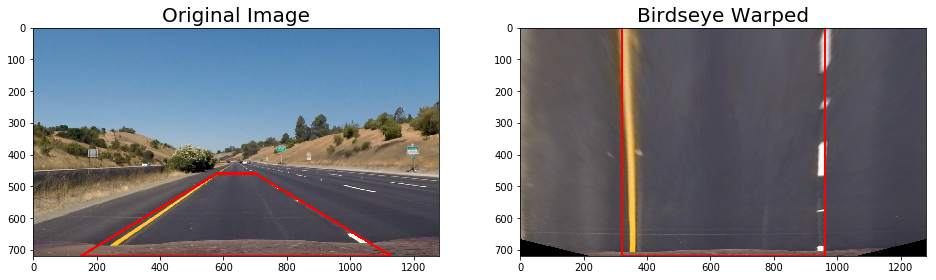

In [745]:
fname = './test_images/straight_lines1.jpg' 
img = cv2.imread(fname)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Test warped function:
offset = 100 # offset for dst points
# Grab the image shape
img_size = (gray.shape[1], gray.shape[0])

# For source points I'm grabbing the outer four detected corners
src = np.float32(
    [[(0 + 150), img_size[1]],
    [(img_size[0]/2) - 60, (img_size[1] / 2+100)],
    [(img_size[0]/2) + 60, (img_size[1] / 2+100)],
    [(img_size[0] - 150), (img_size[1])]])
    
# For destination points, I'm arbitrarily choosing some points to be
# a nice fit for displaying our warped result 
# again, not exact, but close enough for our purposes
dst = np.float32(
    [[(img_size[0] / 4), img_size[1]],
    [(img_size[0] / 4), 0],
    [(img_size[0] * 3 / 4), 0],
    [(img_size[0] * 3 / 4), img_size[1]]])
# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
# Warp the image using OpenCV warpPerspective()
warped = cv2.warpPerspective(img, M, img_size)
src_int = np.array(src,np.int32).reshape((-1,1,2))
img = cv2.polylines(img, [src_int],True,color=(255,0,0),thickness=5)
warped=cv2.rectangle(warped,tuple(dst[0]),tuple(dst[2]),(255,0,0), thickness = 5)

# Visualize changes
fig = plt.figure(figsize=(16,5))
ax1 = fig.add_subplot(121)
ax1.set_title('Original Image', fontsize=20)
ax1.imshow(img)
ax2 = fig.add_subplot(122)
ax2.set_title('Birdseye Warped', fontsize=20)
ax2.imshow(warped)
fig.savefig('./output_images/orig_vs_birdseye_warped', bbox_inches='tight')

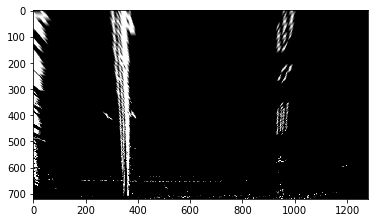

In [742]:
# Perspective Transform helper function using the bright road image processed in the gradient section
def warper(image, src, dst):
    offset = 100 # offset for dst points
    # Grab the image shape
    img_size = (gray.shape[1], gray.shape[0])

    # For source points I'm grabbing the outer four detected corners
    #src = np.float32([[544,491],[780,491],[304,679],[1123,679]])
    # For destination points, I'm arbitrarily choosing some points to be
    # a nice fit for displaying our warped result 
    # again, not exact, but close enough for our purposes
    #dst = np.float32([[200,26], [1000,26], 
    #                             [200,685], 
    #                             [1000,685]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    binary_warped = cv2.warpPerspective(image, M, img_size)
    return binary_warped

binary_warped = warper(combined, src, dst)
plt.imshow(binary_warped, cmap = 'gray')

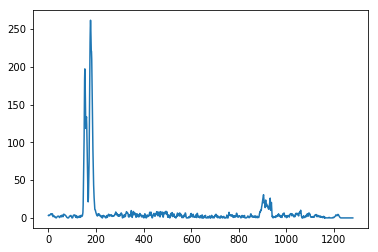

In [589]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

## Finding Lanes
We now use a histogram to find the peaks of where white pixels are to determine where lane lines are.


In [732]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [747]:
def get_lane_pix(binary_warped, nwindows=9, margin = 100, minpix =50):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    return left_fit,right_fit

In [748]:
left_lane = Line()
right_lane = Line()
left_lane.current_fit, right_lane.current_fit = get_lane_pix(binary_warped)


(720, 0)

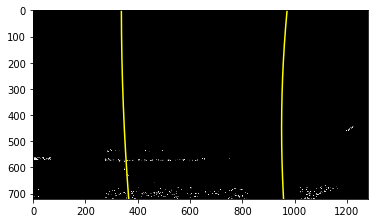

In [749]:
# VIsualize Result
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_lane.current_fit[0]*ploty**2 + left_lane.current_fit[1]*ploty + left_lane.current_fit[2]
right_fitx = right_lane.current_fit[0]*ploty**2 + right_lane.current_fit[1]*ploty + right_lane.current_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, binary_warped.shape[1])
plt.ylim(binary_warped.shape[0], 0)

In [587]:
# Set Sliding window 
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

(720, 0)

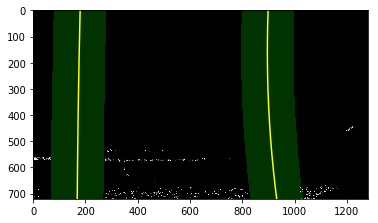

In [588]:
# Visualize Result
# Create an image to draw on and an image to show the selection window
def draw_lanes():
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)


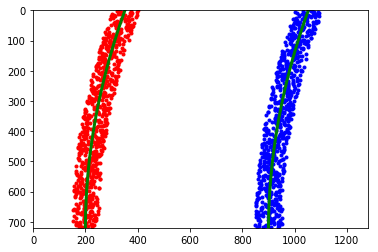

In [590]:
# Measure curvature
import numpy as np
import matplotlib.pyplot as plt
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images

In [591]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

1744.58521271 1753.55687258


In [592]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

573.000509693 m 575.924851766 m


In [571]:
# Test Pipeline on all images in the test_images folder
test_image_folder = "test_images/"
test_image_output_folder = "output_images/"

# Create output folder if it doesn't exist
if not os.path.exists(test_image_output_folder):
    os.makedirs(test_image_output_folder)
    
# Helper method to process image:
def process_image(img):
    left_lane = Line()
    right_lane = Line()
    # First undistort radial distortions
    undistort = cal_undistort(img, objpoints, imgpoints)
    
    # Extract R & G colors and HSV Value channel
    gradient = extract_lane_gradient(undistort)
    
    # Get lane birdseye perspective
    lane = cv2.warpPerspective(gradient, M, gradient.shape)
    left_lane.
    return lane
    
#Repeat above for all images:
for filename in os.listdir(test_image_folder):
    img = mpimg.imread(os.path.join(test_image_folder,filename))
    
    output = process_image(img)
    
    # Uncomment the following code if you are running the code locally and wish to save the image
    mpimg.imsave(os.path.join(test_image_output_folder,"%s" %(filename)), lane)

In [ ]:
# Run pipeline for videos
# Install imagio to use moviepy
import imageio
imageio.plugins.ffmpeg.download()
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Create video Output folder
test_video_output_folder = "test_videos_output/"

# Create output folder if it doesn't exist
if not os.path.exists(test_video_output_folder):
    os.makedirs(test_video_output_folder)
white_output = "%ssolidWhiteRight.mp4" %(test_video_output_folder)


## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#%time 
white_clip.write_videofile(white_output, audio=False)

In [ ]:
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#%time 
white_clip.write_videofile(white_output, audio=False)

In [ ]:
clip1 = VideoFileClip("harder_challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
#%time 
white_clip.write_videofile(white_output, audio=False)